In [10]:
import datetime
import pyaurorax
import matplotlib.pyplot as plt

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools
at.set_theme("dark")

# Create TREx Spectrograph keogram

Below, we"ll work through the creation of a 1 hour keogram created from TREx Spectrograph data, for various emissions wavelengths.

In [2]:
# download an hour of TREx Spectrograph data
dataset_name = "TREX_SPECT_PROCESSED_V1"
start_dt = datetime.datetime(2021, 2, 16, 9, 0)
end_dt = datetime.datetime(2021, 2, 16, 9, 59)
site_uid = "rabb"
r = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

In [3]:
# read in the data
data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)

## Generate keogram

Making a keogram for the spectrograph data is a bit different to ASIs because of the nature of the instrument. Instead of taking the middle slice of each image and stacking them horizontally, we specify the wavelength which works as the middle slice. 

In [4]:
# create the keogram
#
# NOTE: if no emission is specified, the function defaults to the
# greenline emission (557.7 nm) for spectrograph data.
keogram = at.keogram.create(data.data, data.timestamp, spectra=True, wavelength=data.metadata[0]["wavelength"])

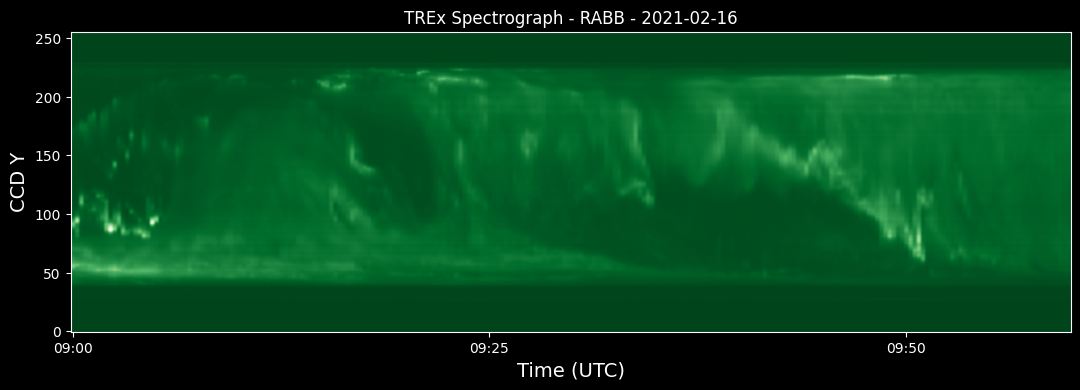

In [9]:
# plot the keogram
keogram.plot(
    figsize=(10, 3),
    aspect="auto",
    cmap="Greens_r",
    title=f"TREx Spectrograph - {site_uid.upper()} - {start_dt.date()}",
)

## Keograms for various wavelengths

Now let"s make four keograms, one for each of the available spect_emission options. 

To look at emissions that are not included, wavelength integration ranges for emissions and background subtraction can be passed using the spect_band and spect_band_bg parameters.


In [11]:
# pull out the data to be used for all keograms
data_arr = data.data
timestamps = data.timestamp
wavelengths = data.metadata[0]["wavelength"]

# create the keograms for each emission
keogram_hbeta = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="hbeta")
keogram_4278 = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="blue")
keogram_5577 = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="green")
keogram_6300 = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="red")

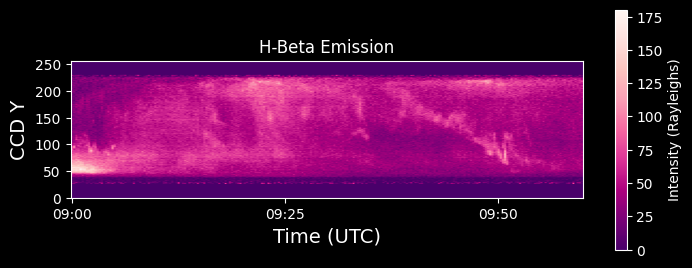

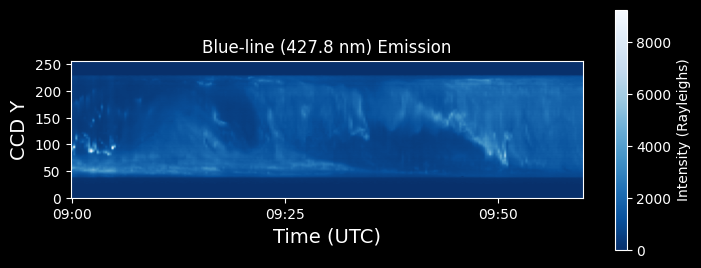

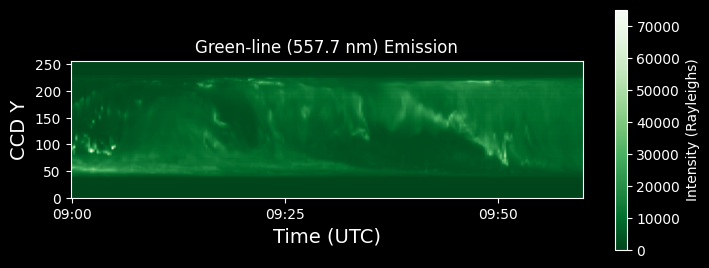

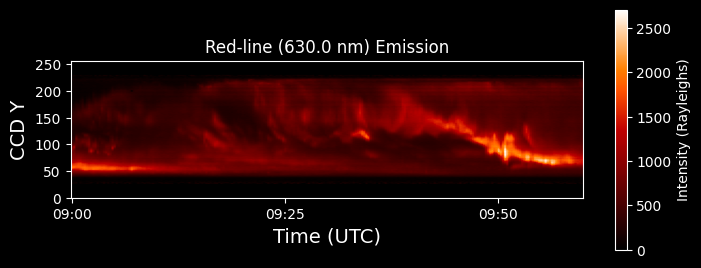

In [12]:
# plot all four keograms
fig, ax = keogram_hbeta.plot(cmap="RdPu_r", title=f"H-Beta Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")

fig, ax = keogram_4278.plot(cmap="Blues_r", title=f"Blue-line (427.8 nm) Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")

fig, ax = keogram_5577.plot(cmap="Greens_r", title=f"Green-line (557.7 nm) Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")

fig, ax = keogram_6300.plot(cmap="gist_heat", title=f"Red-line (630.0 nm) Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")
